In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import sys
import pathlib

In [2]:
tf.debugging.set_log_device_placement(False)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Found GPU at: /device:GPU:0
Num GPUs Available:  1


# Importing My Own Functions

In [4]:
import run_fast_dir

In [5]:
tf.__version__

'2.8.0-dev20211216'

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (200, 200)

all_data_dir = './Data/imagewoof_all/'

data_dir = pathlib.Path(all_data_dir)
image_count = len(list(data_dir.glob('*/*.JPEG')))
print(f'Total images found {image_count}')

Total images found 12954


# Train, Test, Split

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=123,
                                                            image_size=IMG_SIZE ,
                                                            batch_size=BATCH_SIZE)

Found 12954 files belonging to 10 classes.
Using 10364 files for training.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=123,
                                                            image_size=IMG_SIZE ,
                                                            batch_size=BATCH_SIZE)

Found 12954 files belonging to 10 classes.
Using 2590 files for validation.


In [9]:
lbl_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

In [10]:
class_names = train_dataset.class_names
print(class_names)

['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601', 'n02105641', 'n02111889', 'n02115641']


# Moving 20% of validation data to a test set
We do not have a test set therefore will set aside some of the validation data to a test set, this will still overfit our model since our validation data is only 500 images however it is important to see how much of an improvement we can make (will evaluate further down the line).

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [12]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 65
Number of test batches: 16


# Buffered Prefetching
Per [Data Performance Guide](https://www.tensorflow.org/guide/data_performance)I/O can become a problem for the execution time of a training step. Therefore we will need something that enables the configuration of the dataset for peak erformance.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

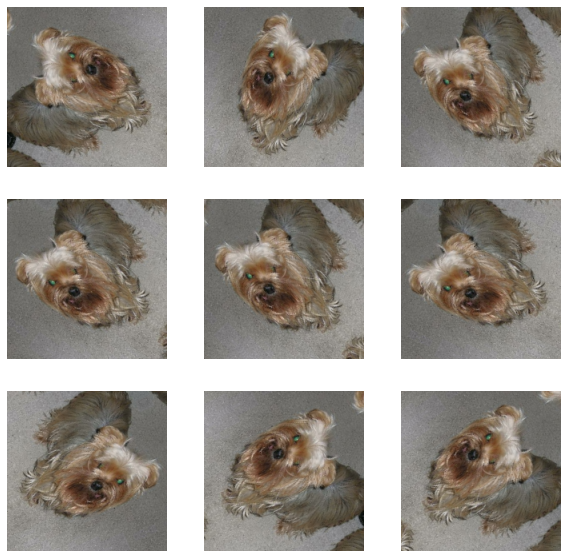

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [16]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [17]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

# Feature Extraction
## Freeze the convolutional base

In [18]:
IMG_SHAPE = IMG_SIZE + (3,)
res_net2 = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

for layer in res_net2.layers:
  layer.trainable = False

In [19]:
x = tf.keras.layers.Flatten()(res_net2.output)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
predictions = tf.keras.layers.Dense(10, activation = 'softmax')(x)

In [20]:
base_learning_rate = 0.0001
head_model = tf.keras.Model(inputs = res_net2.input, outputs = predictions)
head_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
                   loss=tf.keras.losses.sparse_categorical_crossentropy, 
                   metrics=['accuracy'])

In [21]:
len(head_model.trainable_variables)

4

In [22]:
initial_epochs = 10
loss0, accuracy0 = head_model.evaluate(validation_dataset)

65/65 [==============================] - 11s 92ms/step - loss: 4.4353 - accuracy: 0.0818


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.44
initial accuracy: 0.08


In [24]:
history = head_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
324/324 [==============================] - 39s 114ms/step - loss: 0.9577 - accuracy: 0.7804 - val_loss: 0.5607 - val_accuracy: 0.8171
Epoch 2/10
324/324 [==============================] - 37s 114ms/step - loss: 0.1140 - accuracy: 0.9624 - val_loss: 0.6014 - val_accuracy: 0.8277
Epoch 3/10
324/324 [==============================] - 37s 114ms/step - loss: 0.0420 - accuracy: 0.9876 - val_loss: 0.6693 - val_accuracy: 0.8388
Epoch 4/10
324/324 [==============================] - 38s 116ms/step - loss: 0.0259 - accuracy: 0.9921 - val_loss: 0.7189 - val_accuracy: 0.8412
Epoch 5/10
324/324 [==============================] - 38s 117ms/step - loss: 0.0509 - accuracy: 0.9833 - val_loss: 0.8353 - val_accuracy: 0.8359
Epoch 6/10
324/324 [==============================] - 39s 118ms/step - loss: 0.0708 - accuracy: 0.9791 - val_loss: 0.8621 - val_accuracy: 0.8311
Epoch 7/10
324/324 [==============================] - 39s 119ms/step - loss: 0.0654 - accuracy: 0.9811 - val_loss: 0.9964 - val_ac

In [25]:
Trial_num = 4
output_path = './Results/'
folder_name = f'Trial{str(Trial_num)}'

if not os.path.exists(output_path + folder_name):
    os.makedirs(output_path + folder_name)

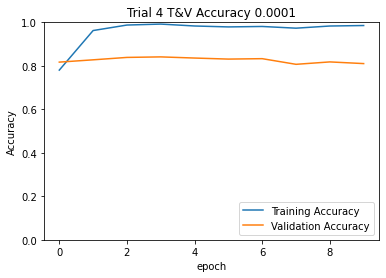

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#plt.figure(figsize=(8, 8))
#plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1])
plt.title(f'Trial {Trial_num} T&V Accuracy {base_learning_rate}')
plt.savefig(output_path + '/' + folder_name + '/' + f'Trial {Trial_num} T&V Accuracy {base_learning_rate}.jpeg')
plt.xlabel('epoch')
plt.show()
#plt.close()

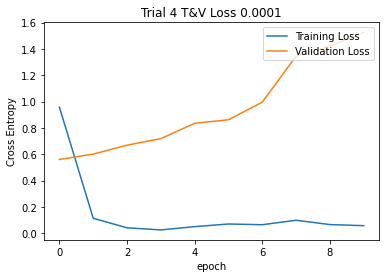

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

#plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title(f'Trial {Trial_num} T&V Loss {base_learning_rate}')
plt.savefig(output_path + '/' + folder_name + '/' + f'Trial {Trial_num} T&V Loss {base_learning_rate}.jpeg')
plt.xlabel('epoch')
plt.show()
#plt.close()

# Unfreeze Base Model

In [28]:
for layer in res_net2.layers:
  layer.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(head_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in head_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  178


In [30]:
# Reducing My Learning Rate
head_model = tf.keras.Model(inputs = res_net2.input, outputs = predictions)
head_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), 
                   loss=tf.keras.losses.sparse_categorical_crossentropy, 
                   metrics=['accuracy'])

In [31]:
len(head_model.trainable_variables)

94

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = head_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
324/324 [==============================] - 79s 221ms/step - loss: 0.0779 - accuracy: 0.9770 - val_loss: 1.0534 - val_accuracy: 0.8369
Epoch 11/20
324/324 [==============================] - 69s 213ms/step - loss: 0.0115 - accuracy: 0.9966 - val_loss: 1.1436 - val_accuracy: 0.8330
Epoch 12/20
324/324 [==============================] - 69s 211ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 1.1637 - val_accuracy: 0.8412
Epoch 13/20
324/324 [==============================] - 69s 212ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 1.1337 - val_accuracy: 0.8474
Epoch 14/20
324/324 [==============================] - 69s 212ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 1.2346 - val_accuracy: 0.8417
Epoch 15/20
324/324 [==============================] - 69s 213ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 1.1676 - val_accuracy: 0.8455
Epoch 16/20
324/324 [==============================] - 69s 213ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 1.2449 -

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

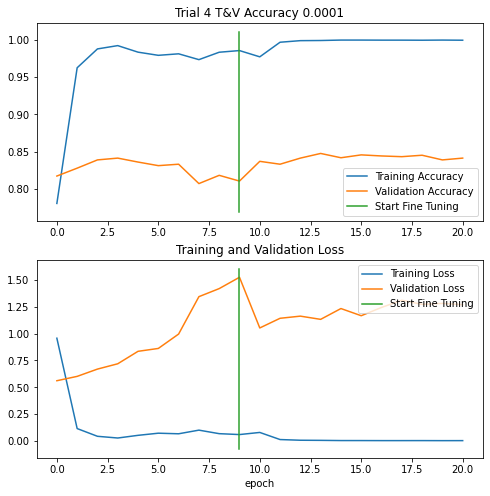

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title(f'Trial {Trial_num} T&V Accuracy {base_learning_rate}')
plt.savefig(output_path + '/' + folder_name + '/' + f'Trial {Trial_num} T&V Accuracy_FineTuned.jpeg')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(output_path + '/' + folder_name + '/' + f'Trial {Trial_num} T&V Loss_FineTuned.jpeg')
plt.show()

# Evaluation and prediction

In [35]:
loss, accuracy = head_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

16/16 [==============================] - 2s 84ms/step - loss: 1.3434 - accuracy: 0.8555
Test accuracy : 0.85546875


In [36]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = head_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

# Confusion Matrix

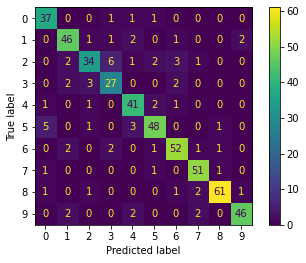

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(predicted_labels, correct_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [41]:
import plot_cm
import plot_to_img

figure = plot_cm.plot_confusion_matrix(cm, class_names=class_names)
cm_image = plot_to_img.plot_to_image(figure)

IndentationError: expected an indented block (plot_cm.py, line 26)